# Lecture 10:  Sparse matrices finale & Iterative methods

## Recap of the previous lecture
- Sparse matrix formats (COO, LIL, CSR)
- Matrix-by-vector product
- Gaussian elimination for sparse matrices and graphs

## Today lecture

- Gaussian elimination and graphs in more details
- Concept of **iterative methods** for linear systems
- Richardson iteration and its convergence, Chebyshev acceleration

## Gaussian elimination and graphs

<img src="gauss_elimination.png" /img>

## Gaussian elimination and graphs
In the symmetric case, $A = A^{\top} > 0$ the sparsity pattern of the matrix $L$ is determined by operations on the graph of the matrix $A$.

The order of elimination is important, since we are adding new edges between neighbors.

## Illustration
The factorization is then a graph operation (on the right there is a sparsity of $L$ for different orderings)
<img src="gauss_elimination2.png" /img>

## Implemenation scheme

1. Preorder: replace A by $PAP^{\top}$ and $b$ by $Pb$ 
   Independent of numerics
2. Symbolic Factorization: build static data structure
 - Elimination tree
 - Nonzero counts
 - Supernodes (separate topic, we do not talk about it)
 - Nonzero structure of $L$
3. Numeric Factorization: $A = LL^{\top}$
 - Static data structure
 - Supernodes use BLAS3 to reduce memory traffic (separate topic)
4. Triangular Solves: solve $Ly = b$, then $L^{\top} x = y$ 

## Permutation selection

The selection of the permutation is done by looking at the graph.

## Nested dissection ordering

 A separator in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components
- A nested dissection ordering for an $N$-vertex graph $G$ numbers its
vertices from $1$ to $N$ as follows:
- Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
- Number the vertices of $S$ from $N − |S| + 1$ to $N$
- Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, number it arbitrarily

It all boils down to finding good separators! 

## Nested dissection is "approximately optimal"

From theory, nested dissection gives you optimal complexity. 

Again, there are other methods that win for medium-sized problems.

They are based on **heuristic** matrix reordering techniques.

## Banded reordering

Make the matrix more "banded" (Reverse Cuhill-McKee, Sloan, etc.). 

The idea is to try to keep entries closer to the diagonal. 

Works well for matrices coming from "quasi-one dimensional" PDEs.

## Minimal degree orderings

The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and then repeat

Efficient implementation is an issue (adding/removing elements).

Current champion is "approximate minimal degree" by Amestoy, Davis, Duff.

It is **suboptimal** even for 2D problems

In practice, often wins for medium-sized problems.

## Nested dissection

- Find a separator, number it last, proceed recursively.
- In theory, optimal.
- In practice, beats others for very large problems.

## Separators in practice

Computing separators is not a **trivial task**.

Graph partitioning heuristics have been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph)
- Geometric partitioning (for meshes with specified vertex coordinates)
- Iterative-swapping (Kernighan-Lin, Fiduccia-Matheysses)
- Breadth-first search 

Many popular modern codes (e.g. Metis, Chaco) use multilevel iterative swapping.

## Iterative swapping

The "cost" of the separator is defined in a very natural way as the sum over edges:

$$T(A, B) = \sum_{e} \{ \mbox{weight}(e): \mbox{ $e$ connects $A$ and $B$} \}.$$

Given some initial partion, test some subsets $X$ and $Y$ of the same size, and if swapping decreases the cost function - swap them.

## Spectral bisection

The idea of spectral bisection goes back to Fiedler.

We need to split the vertices into two.

Consider +1/-1 labeling of vertices and the cost

$$E_c = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2.$$

We need a balanced particion, thus 
$$\sum_i x_i =  0$$
and since we have +1/-1 labels, we have
$$\sum_i x^2_i = n.$$

We now relax the integer programming to the quadratic programming

$$E_c = (Lx, x),$$
where $L$ is the **graph Laplacian**.

## Graph Laplacian
We introduce the **graph Laplacian** of the matrix, which is defined as as a symmetric matrix

as

$$L_{ii} = \mbox{degree of node $i$},$$

$$L_{ij} = -1, \mbox{if $i \ne j$  and there is an edge},$$

and $0$ otherwise.

- Rows of $L$ sum to zero, thus there is an eigenvalue $0$ (why?)
- Eigenvalues are non-negative.
- The number of connected components of a graph is the number of **zero eigenvalues**

## Fiedler vector
The solution is given by the eigenvector corresponding  to the second smallest eigenvalue of the graph Laplacian. The sign $x_i$ corresponds to partitioning.

In computations, we need to find out, how to find this second minimal eigenvalue -- we at least know about power method, but it finds the largest.

This is the main goal of the iterative methods for large-scale linear problems, and

can be achieved via few matrix-by-vector products.

## Interative methods

If we want to get $\mathcal{O}(N)$ complexity, we need to do something else.

If we want to solve partial eigenproblem, we need to do something else.

This "else" are iterative, Krylov subspace solvers, which treat the matrix as a **black-box** linear operator.

## Matrix as a black box

We have now an absolutely different view on a matrix: matrix is now a **linear operator**, that acts on a vector,  

and this action can be computed in $\mathcal{O}(N)$ operations.

**This is the only information** we know about the matrix: the <font color='red'> matrix-by-vector product </font>

Can we solve linear systems?

Of course, we can multiply by the colums of the identity matrix, and recover the full matrix, but it is not what we need.

## Richardson iteration
The simplest idea is the **"simple iteration method"** or **Richardson iteration**.  


  $$Ax = f,$$
  $$\tau  (Ax - f) = 0,$$
   $$x - \tau (Ax - f) = x,$$
   $$x_{k+1} = x_k - \tau (Ax_k - f),$$
   
   where $\tau$ is the **iteration parameter**, which can be always chosen such that the method **converges**.

## Convergence of the Richardson method
Let $x_*$ be the solution; introduce an error $e_k = x_{k} - x_*$, then  

$$
     e_{k+1} = (I - \tau A) e_k,
$$

therefore if $\Vert I - \tau A \Vert < 1$ the iteration converges. 

For symmetric positive definite case it is always possible to select $\tau.$

What about the non-symmetric case?

## Optimal parameter choice
The optimal choice for $\tau$ for $A = A^* > 0$ is (prove it!)
$$
  \tau = \frac{2}{\lambda_{\min} + \lambda_{\max}}.
$$

where $\lambda_{\min}$ is the minimal eigenvalue, and $\lambda_{\max}$ is the maximal eigenvalue of the matrix $A$.

So, to find optimal parameter, we need to know the **bounds of the spectra** of the matrix $A$,

and we can compute it by using **power method**.`

## Connection to ODEs

The Richardson iteration has a deep connection to the Ordinary Differential Equations (ODE).


Consider a time-dependent problem

$$\frac{dy}{dt} + A y = f, \quad y(0) = y_0.$$

Then $y(t) \rightarrow A^{-1} f$ as $t \rightarrow \infty$, and the **Euler scheme** reads

$$\frac{(y_{k+1} - y_k)}{\tau} = -A y_k + f.$$

## Convergence speed and condition number

Even with the optimal parameter choice, the error at the next step satisfies

$$e_{k+1} \leq e_k q, \rightarrow e_k \leq c q^k,$$

where 

$$
   q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{c - 1}{c+1},
$$

$$c = \frac{\lambda_{\max}}{\lambda_{\min}} = \mathrm{cond}(A)$$

is the condition number of $A$.

Let us do some demo...

((-0.0058683976325190276+0j), (-3.994131602367494+0j))

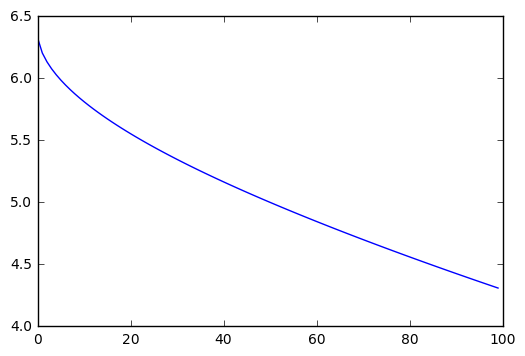

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 40
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigs(lp1, k=2, which='LR')
ev2, vec = spla.eigs(lp1, k=2, which='SR')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 100
x = np.zeros(n)
res_all = []
for i in xrange(niters):
    rr = lp1.dot(x) - rhs
    x = x - tau_opt * rr
    res_all.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.plot(res_all)
lam_max, lam_min

## Condition number of and convergence speed
Thus, for **ill-conditioned** matrices the error of the simple iteration method decays very slowly.

This is another reason why **condition number** is so important:

1. It gives the bound on the error in the solution

2. It gives an estimate of the number of iterations for the iterative methods.

Main questions for the iterative method is how to make the matrix **better conditioned** 

The answer is <font color='red'> use preconditioners </font>

## Better iterative methods

But before preconditioners, we need to use **better iterative methods**. 

There is a whole **zoo** of iterative methods, but we need to know just few of them.

## Attempt 1: Different time steps

Suppose we **change** $\tau$ every step, i.e. 
$$
   x_{k+1} = x_k - \tau_k (A x_k - f).
$$

Then, $$e_{k+1} = (I - \tau_k A) e_k = (I - \tau_k A) (I - \tau_{k-1} A)  e_{k-1} = \ldots = p(A) e_0, $$

where $p(A)$ is a **matrix polynomial** (simplest matrix function)  

$$
   p(A) = (I - \tau_k A) \ldots (I - \tau_0 A),
$$

and $p(0) = 1$.

## Optimal choice of the time steps
The error is written as 

$$e_{k+1} = p(A) e_0, $$
and hence
$$\|e_{k+1}\| \leq \|p(A)\| \|e_0\|, $$
where $p(0) = 1$ and $p(A)$ is a **matrix polynomial**. 

To get better **error reduction**, we need to minimize

$$\Vert p(A) \Vert$$ over all possible polynomials.

##  Polynomials least deviating from zeros

Important special case: $A = A^* > 0$.

Then $A = U \Lambda U^*$, 

and 



$$\Vert p(A) \Vert_2 = \Vert U p(\Lambda) U^* \Vert_2 = \Vert p(\Lambda) \Vert_2 = \max_k |p(\lambda_k)| \leq 
\max_{a \leq \lambda \leq b} p(\lambda).$$

Thus, we need to find a polynomial such that $p(0) = 1$, that has the least possible deviation from $0$ on a given interval $[a, b]$.

##  Polynomials least deviating from zeros (2)

We can do the affine transformation of the interval $[a, b]$ to the interval $[-1, 1]$.

The problem is then reduced to the problem of finding the **polynomial least deviating from zero** on an interval $[-1, 1]$ 

with some normalization constraint $p(c) = 1$.


## Exact solution: Chebyshev polynomials

The exact solution to this problem is given by the famous **Chebyshev polynomials** of the form

$$T_n(x) =  \cos (n \arccos x)$$

## What do you need to know about Chebyshev polynomials

1. This is a polynomial! (we can express $T_n$ from $T_{n-1}$ and $T_{n-2}$).

2. $|T_n(x)| \leq 1$ on $x \in [-1, 1]$.

3. It has $(n+1)$ **alternation points**, were the the maximal absolute value is achieved (this is the sufficient and necessary condition for the **optimality**

4. The **roots** are just  
$n \arccos x_k = \frac{\pi}{2} + \pi k, \rightarrow x_k = \cos \frac{\pi(k + 0.5)}{n}$

We can plot them...

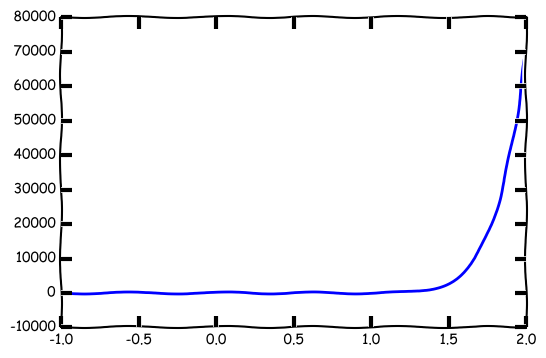

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
%matplotlib inline
x = np.linspace(-1, 2, 128)
p = np.polynomial.Chebyshev((0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (-1, 1)) #These are Chebyshev series, a proto of "chebfun system" in MATLAB
plt.plot(x, p(x))

## Convergence of the Chebyshev-accelerated Richardson iteration

Given the roots of the polynomials $x_k$, the best parameters are determined as 

$$\tau_k = \frac{1}{x_k}.$$

The convergence (we only give the result without the proof) is now given by

$$
   e_{k+1} \leq c q^k, \quad q = \frac{\sqrt{c}-1}{\sqrt{c}+1},
$$

where $c = \mathrm{cond}(A)$.


## Beyond Chebyshev

We have made an important assumption about the spectra: it is contained within an interval over the real line (and we need to know the bounds)

If the spectra is contained within **two intervals**, and we know the bounds, we can also put the optimization problem 

for the **optimal polynomial**.



## Spectra of the matrix contain on multiple segments

For the case of **two segments** the best polynomial is given by **Zolotarev polynomials** (expressed in terms of elliptic functions)

For the case of **more than two segments** the best polynomial can be expressed in terms of **hyperelliptic functions**

## How can we make it better

The implementation of the Chebyshev acceleration requires the knowledge of the spectra.

It only stores the **previous vector** $x_k$ and computes the new correction vector

$$r_k = A x_k - f.$$

It belongs to the class of **two-term** iterative methods.

It appears that if we **abandon** this and **store more vectors**, then we can go without the spectra estimation (and better convergence in practice)!

## Crucial point: Krylov subspace

The Chebyshev method produces the approximation of the form

$$x_{k+1} = p(A) f,$$

i.e. it lies in the the **Krylov subspace** of the matrix  which is defined as

$$
   K(A, f) = \mathrm{Span}(f, Af, A^2 f, \ldots, )
$$

The most natural approach then is to find the vector in this **linear subspace** that minimizes 

certain **norm of the error**

## Take home message

- Finalized Gaussian elimination and connection to graphs
- Introduced two iterative methods: simple iteration and Chebyshev acceleration

## Next lecture

- Main iterative methods: conjugate gradient, GMRES, ...
- Lanczos and Arnoldi orthogonalization of Krylov subspaces, optimality result for Krylov subspaces
- Convergence estimates
- Iterative Methods for eigenvalue problems

# Questions?

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()